In [160]:
import os
import torch
from torch.utils.data import Dataset, random_split
import wfdb
import numpy as np
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from tqdm import tqdm

def normalize(data):
    data = np.nan_to_num(data)  # removing NaNs and Infs
    data = data - np.mean(data)
    data = data / np.std(data)
    return data

class MITBIHDataset(Dataset):
    def __init__(self, data_folder, split='train', segmentation_type='rpeak', seconds_time_segmentation=5):
        self.data_folder = data_folder
        self.freq = 360

        train = [101, 102, 104, 106, 107, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 217, 220, 223, 230]
        test = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

        self.records = train if split == 'train' else test
        self.segmentation_type = segmentation_type
        self.seconds_time_segmentation = seconds_time_segmentation
        self.labels = self.load_labels()

    def load_labels(self):
        labels = {}
        for record in self.records:
            annotation = wfdb.rdann(os.path.join(self.data_folder, f'{record}'), 'atr')
            sample_labels = []

            for i, (symbol, sample) in enumerate(zip(annotation.symbol, annotation.sample)):
                if sample > 649800 and self.segmentation_type == 'time':
                    # In case of time segmentation, we only consider the first 649800 samples because of divisibility by 360
                    pass
                if symbol in ['N', 'L', 'R', 'e', 'j']: 
                    sample_labels.append({sample: 0})  # Normal
                elif symbol in ['A', 'a', 'J', 'S']:
                    sample_labels.append({sample: 1})  # Supraventricular ectopic
                elif symbol in ['V', 'E']: 
                    sample_labels.append({sample: 2})  # Ventricular ectopic
                elif symbol in ['F']: 
                    sample_labels.append({sample: 3})  # Fusion
                elif symbol in ['/', 'f', 'Q']:
                    sample_labels.append({sample: 4})  # Unknown
                else:
                    pass
            labels[record] = np.array(sample_labels)
        return labels

    def __len__(self):
        if self.segmentation_type == 'rpeak':
            return sum(len(self.labels[r]) for r in self.records)
        else:
            return ((650000 // self.freq) // self.seconds_time_segmentation) * len(self.records) 
    
    def get_item_r_peak_seg(self, idx):
        # the id of the patient
        record_idx = 0
        # the id of the sample
        sample_idx = idx

        while True:
            # if the sample index is less than the number of samples in the record ad record_idx
            # then keep the record index and break the loop
            if sample_idx<len(self.labels[self.records[record_idx]]):
                break
            # otherwise subtract the number of samples in the record from the sample index
            # and increase the record index by 1
            sample_idx-=len(self.labels[self.records[record_idx]])
            record_idx+=1

        #print(f'Record index: {record_idx}, sample index: {sample_idx}')

        record = self.records[record_idx]

        signal, _ = wfdb.rdsamp(os.path.join(self.data_folder, f'{record}'))
        signal = normalize(signal)
        #print(f'Signal shape: {signal.shape}')

        label = self.labels[record][sample_idx]

        r_peak = list(label.keys())[0]
        start_recording = r_peak - 100 if r_peak - 100 > 0 else 0
        end_recording = r_peak = 180 if r_peak + 180 < len(signal) else len(signal)
        #print(f'End recording: {list(label.keys())[0]}')

        #print(f'Label: {list(label.values())[0]}')
    

        return {'signal': torch.tensor(signal[start_recording:end_recording], dtype=torch.float32), 
                'label': torch.tensor(list(label.values())[0], dtype=torch.float32)}
    
    def get_item_time_seg(self, idx, seconds):
        total_sec = 650000 // self.freq
        record_idx = int(idx // (total_sec / seconds))
        sample_idx = int(idx % (total_sec / seconds))

        #print(f'Record index: {record_idx}, sample index: {sample_idx}')
        #print(f'Total seconds: {total_sec}')
        #print(f'Total samples: {total_sec / seconds}')
        #print(f'toal len record: {len(self.records)}')


        record = self.records[record_idx]
        start_recording = sample_idx * self.freq
        end_recording = start_recording + self.freq * seconds

        signal, _ = wfdb.rdsamp(os.path.join(self.data_folder, f'{record}'))
        signal = signal[start_recording:end_recording]
        labels = [list(label.values())[0] for label in self.labels[record] if list(label.keys())[0] >= start_recording and list(label.keys())[0] < end_recording]
        #print('labels', labels)

        # if all labels are 0, then the label is 0, otherwise it is the most common label not considering the zeros
        if all(label == 0 for label in labels):
            label = 0 
        else:
            labels_without_zero = set([l for l in labels if l != 0])
            label = max(labels_without_zero, key=labels.count)
            if len(labels_without_zero) > 1:
                print('more than one label', labels)

        return {'signal': torch.tensor(signal, dtype=torch.float32),
                'label': torch.tensor(label, dtype=torch.float32)}
    
    def __getitem__(self, idx):
        if self.segmentation_type == 'rpeak':
            return self.get_item_r_peak_seg(idx)
        else:
            return self.get_item_time_seg(idx, self.seconds_time_segmentation)

train_dataset = MITBIHDataset(data_folder='data', split='train', segmentation_type='rpeak', seconds_time_segmentation=2)
labels = []

  4%|▍         | 2244/59782 [00:41<17:43, 54.12it/s]


KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(len(train_dataset))):
    sample = train_dataset[i]
    labels.append(sample['label'].item())

# print the number of samples for each class
print('Number of samples for each class')
print({label: labels.count(label) for label in set(labels)})
print('Total number of samples:', len(labels))

In [127]:
record_idx = 650000 // 360
print(record_idx)

1805


annotation.symbol len: 2311
annotation.symbol: ['+', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', '~', 'f', 'f', '/', '/', '~', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', 'f', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', 'f', '/', '/', '/', '/', '~', '/', '+', 'Q', 'Q', 'Q', '+', '/', '/', '~', '/', '/', '/', 'f', 'f', '/', '/', '/', '/', '/', '/', 'N', 'f', 'f', '/', '/', '/', '/', '/', 'f', 'f', 'f', 'f', '/', '/', '/', '/', '/', '/', '+', 'N', 'N', 'f', 'f', '+', '/', '/', '/', '/', '/', '/', 'N', 'f', 'f', '/', '/', '/', '~', '/', '/', '/', 'N', 'f', '/', '/', '/', '/', '/', '/', 'N', 'f', 'f', '~', '/', '/', '/', '/', '/', '/', 'f', 'N', 'f', 'f', '/', '/', '/', '/', '/', '/', '/', 'f', 'N', 'f', 'f', '/', '/', '/', '/', '/', '/', '/', '/', 'f', 'N', 'f', 'f', 'f', '~', 'f', '/', '/', '/

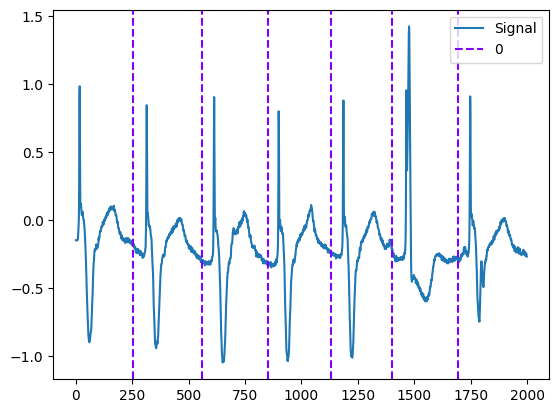

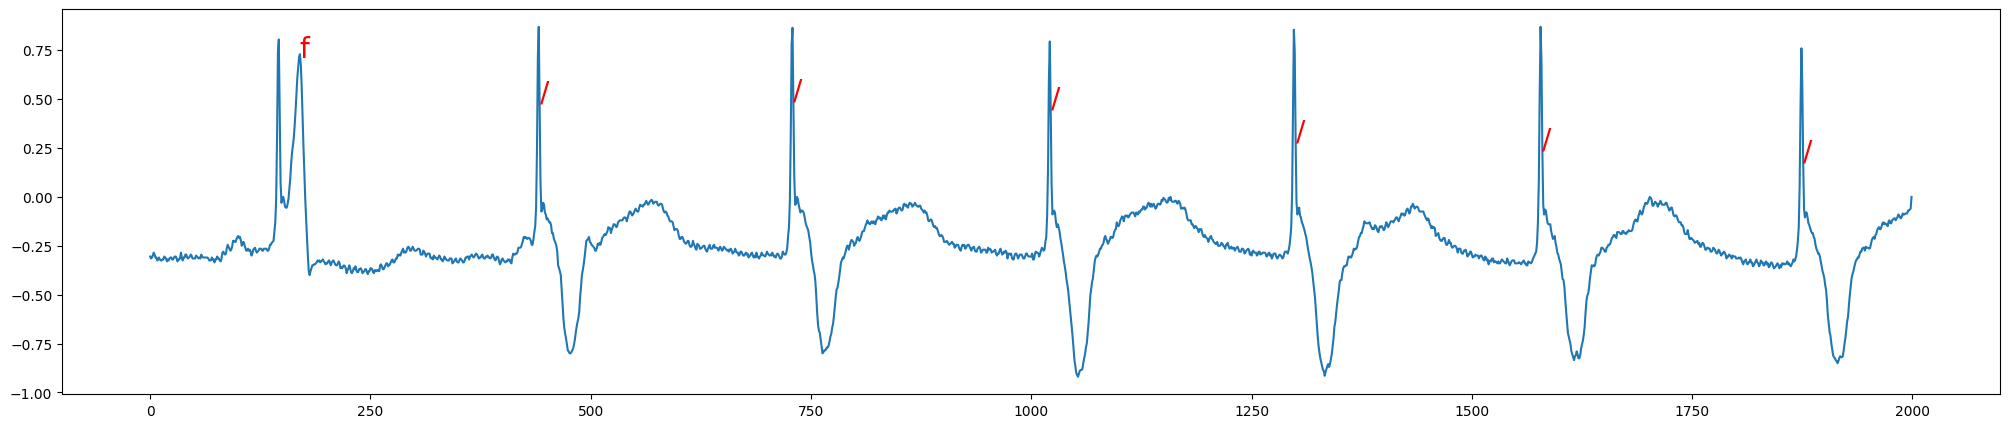

In [155]:
import neurokit2 as nk

annotation = wfdb.rdann('/media/luna97/MIT-BHI/data/104', 'atr')
print(f'annotation.symbol len: {len(annotation.symbol)}')
print(f'annotation.symbol: {annotation.symbol}')
print(f'annotation.sample len: {len(annotation.sample)}')
print(f'annotation.sample: {annotation.sample}')

signal, _ = wfdb.rdsamp('/media/luna97/MIT-BHI/data/104')
print(f'signal len: {len(signal)}')
print(f'signal shape: {signal.shape}') 

r_peaks = [s for s in annotation.sample if s < 2000]

signals, waves = nk.ecg_delineate(signal[:2000, 0], r_peaks, show=False, sampling_rate=360)

nk.events_plot([waves["ECG_P_Offsets"]], signal[:2000, 0])
print(f'waves: {waves.keys()}')

import matplotlib.pyplot as plt

# Plot the signal
plt.figure(figsize=(25, 5))
plt.plot(signal[648000:650000, 0])
print(f'signal[6480000:650000, 0]: {signal[648000:650000, 0]}')

# Plot the annotation symbols
for symbol, sample in zip(annotation.symbol, annotation.sample):
    if sample < 650000 and sample > 648000:  # Only plot symbols within the first 1000 samples
        print(f'{sample}: {symbol}')
        plt.text(sample - 648000, signal[sample, 0], symbol, color='red', fontsize=20)

plt.show()


IndexError: list assignment index out of range